In this notebook, we carry out multi-output batch Bayesian optimization to attain a next proposal for the cement mixtures.

In [1]:
import pandas as pd
import torch 
import botorch
import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['axes.facecolor'] = 'white'

## System Setup

In [3]:
# moving into the repo
import os

repo_name = "SustainableConcrete"
# modify to point to local repository location
repo_dir = "/Users/sebastianament/Code/" + repo_name
#if not os.getcwd()[-len(repo_name) :] == repo_name:
os.chdir(repo_dir)
os.getcwd()

'/Users/sebastianament/Code/SustainableConcrete'

In [4]:
import sys
if repo_dir not in sys.path:
   sys.path.append(repo_dir)

In [5]:
import utils 

data_path = "data/compressive_strength.csv"
data = utils.load_concrete_strength(
    data_path=data_path,
    verbose=False,
)

## Define and Fit Model
1. fit strength model
2. fit GWP model
3. unify as composition-input-only with fixed-time outputs

In [6]:
import models

In [7]:
model_strength_days = [1, 28]  # the strength days that are converted to optmization objectives
model = models.SustainableConcreteModel(strength_days=model_strength_days)

In [8]:
model.fit_gwp_model(data)

Bounds do not hold in training data: X_bounds[0, :], X.amin(dim=0) = (tensor([  0.,   0.,   0.,  35.,   0., 925.,   0.]), tensor([  37.0000,    0.0000,    0.0000,   32.0000,    0.0000, 1132.5000,
           4.5000], dtype=torch.float64))X_bounds[1, :], X.amax(dim=0) = (tensor([ 950.,  950.,  950.,  475.,   95., 1775.,   40.]), tensor([ 671.,  225.,  325.,  238.,   10., 1768.,   22.], dtype=torch.float64))


SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): LogTransformedInterval(1.000E-04, 1.000E+00)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): LinearKernel(
    (raw_variance_constraint): Positive()
  )
  (outcome_transform): Standardize()
  (input_transform): Normalize()
)

In [9]:
model.fit_strength_model(data, use_fixed_noise=False)

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): LogTransformedInterval(1.000E-06, 1.000E+00)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): MaternKernel(
          (raw_lengthscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+03)
        )
        (raw_outputscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+02)
      )
      (1): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+03)
        )
        (raw_outputscale_constraint): LogTransformedInterval(1.000E-02, 1.000E+02)
      )
    )
  )
  (outcome_transform): Standardize()
  (input_transform): ChainedInputTransform(
    (tf1): AffineInputTransform()
    (tf2): Log10()
    (tf3): Normalize()
  )
)

In [10]:
model.strength_model.likelihood.noise

tensor([0.0315], dtype=torch.float64, grad_fn=<ExpBackward0>)

In [11]:
model_list = model.get_model_list()

In [12]:
# NOTE: the original search space bounds are not satisfied by some of the Ozinga data.
X, Y, Yvar, X_bounds = data.gwp_data
ind = range(len(X))
post_list = model_list.posterior(X)

Bounds do not hold in training data: X_bounds[0, :], X.amin(dim=0) = (tensor([  0.,   0.,   0.,  35.,   0., 925.,   0.]), tensor([  37.0000,    0.0000,    0.0000,   32.0000,    0.0000, 1132.5000,
           4.5000], dtype=torch.float64))X_bounds[1, :], X.amax(dim=0) = (tensor([ 950.,  950.,  950.,  475.,   95., 1775.,   40.]), tensor([ 671.,  225.,  325.,  238.,   10., 1768.,   22.], dtype=torch.float64))


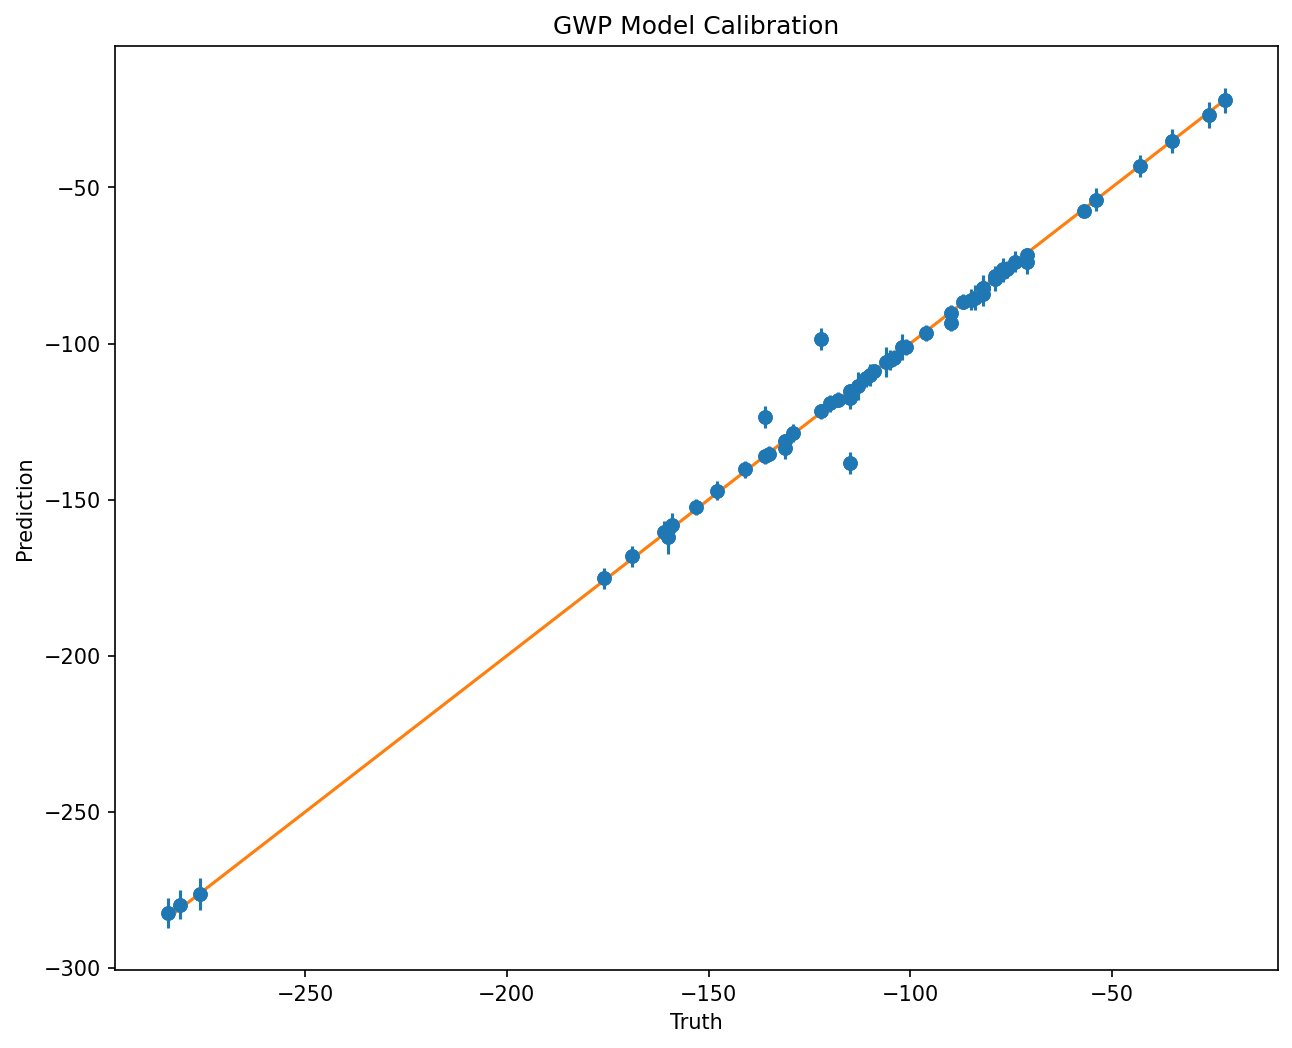

In [13]:
CHECK_gwp = True

if CHECK_gwp:
    obj_id = 0
    # Y[ind], post_list.mean[:, 0], Yvar[ind], post_list.variance[:, obj_id] # variance for GWP looking good, since it gets rounded to ~ 1%.
    truth = Y[ind]
    pred = post_list.mean[:, 0].detach()
    truth_std = Yvar[ind][ind].sqrt().detach()
    pred_std = post_list.variance[:, obj_id].sqrt().detach()
    plt.figure(dpi=150)
    plt.title("GWP Model Calibration")
    plt.ylabel("Prediction")
    plt.xlabel("Truth")
    plt.scatter(truth, pred)
    plt.errorbar(truth, pred, yerr=2*pred_std, fmt="o")
    line = torch.arange(truth.min(), truth.max())
    plt.plot(line, line)
    plt.show()

In [14]:
model.gwp_model.posterior(torch.tensor([500, 0, 0, 100, 1.3, 16.0, 1375]).unsqueeze(0)).mean

tensor([[-62.9705]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)

In [15]:
model.strength_model.likelihood.noise

tensor([0.0315], dtype=torch.float64, grad_fn=<ExpBackward0>)

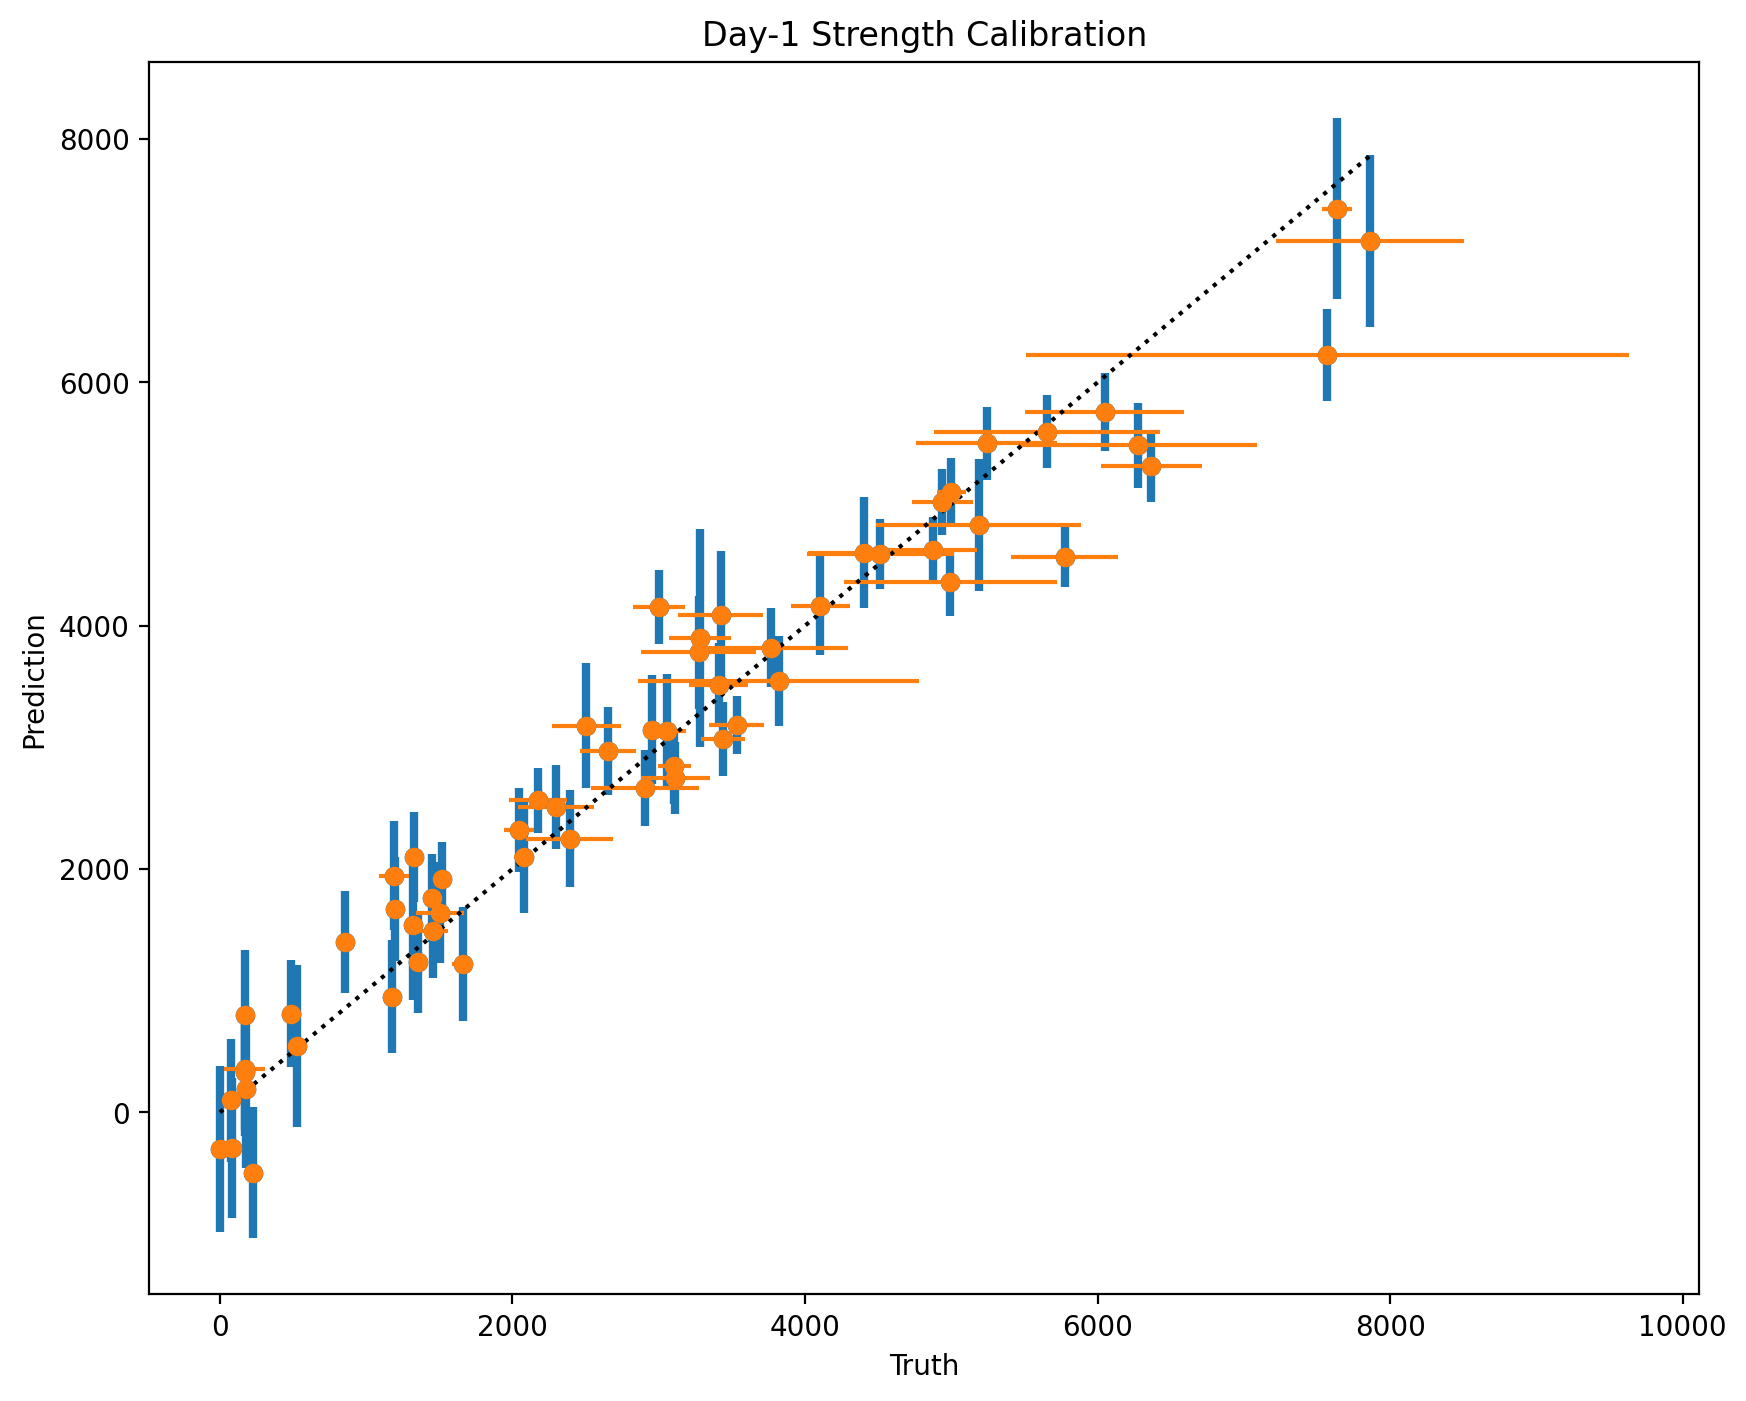

In [16]:
CHECK_1day = True

if CHECK_1day:
    time = 1
    Xt, truth, truth_var = data.strength_data_by_time(time)
    truth_std = truth_var.sqrt()
    obj_id_post = 1 # 0 is GWP, 1 is 1 day, 2, is 28-day strength
    pred = post_list.mean[:, obj_id_post].detach()
    pred_std = post_list.variance[:, obj_id_post].sqrt().detach()

    fig = plt.figure(dpi=200)
    plt.title(f"Day-{time} Strength Calibration")
    plt.ylabel("Prediction")
    plt.xlabel("Truth")
    plt.scatter(truth, pred)
    lw = 3
    plt.errorbar(truth, pred, yerr=2 * pred_std, fmt="o", linewidth=lw)
    plt.errorbar(truth.squeeze(), pred, xerr=2 * truth_std.squeeze(), fmt="o", linewidth=lw/2)
    line = torch.arange(truth.min(), truth.max())
    plt.plot(line, line, color="black", linestyle=":")
    plt.show()

In [17]:
# fig.savefig("1_day_strength_callibration_fourth_batch.pdf", bbox_inches='tight')

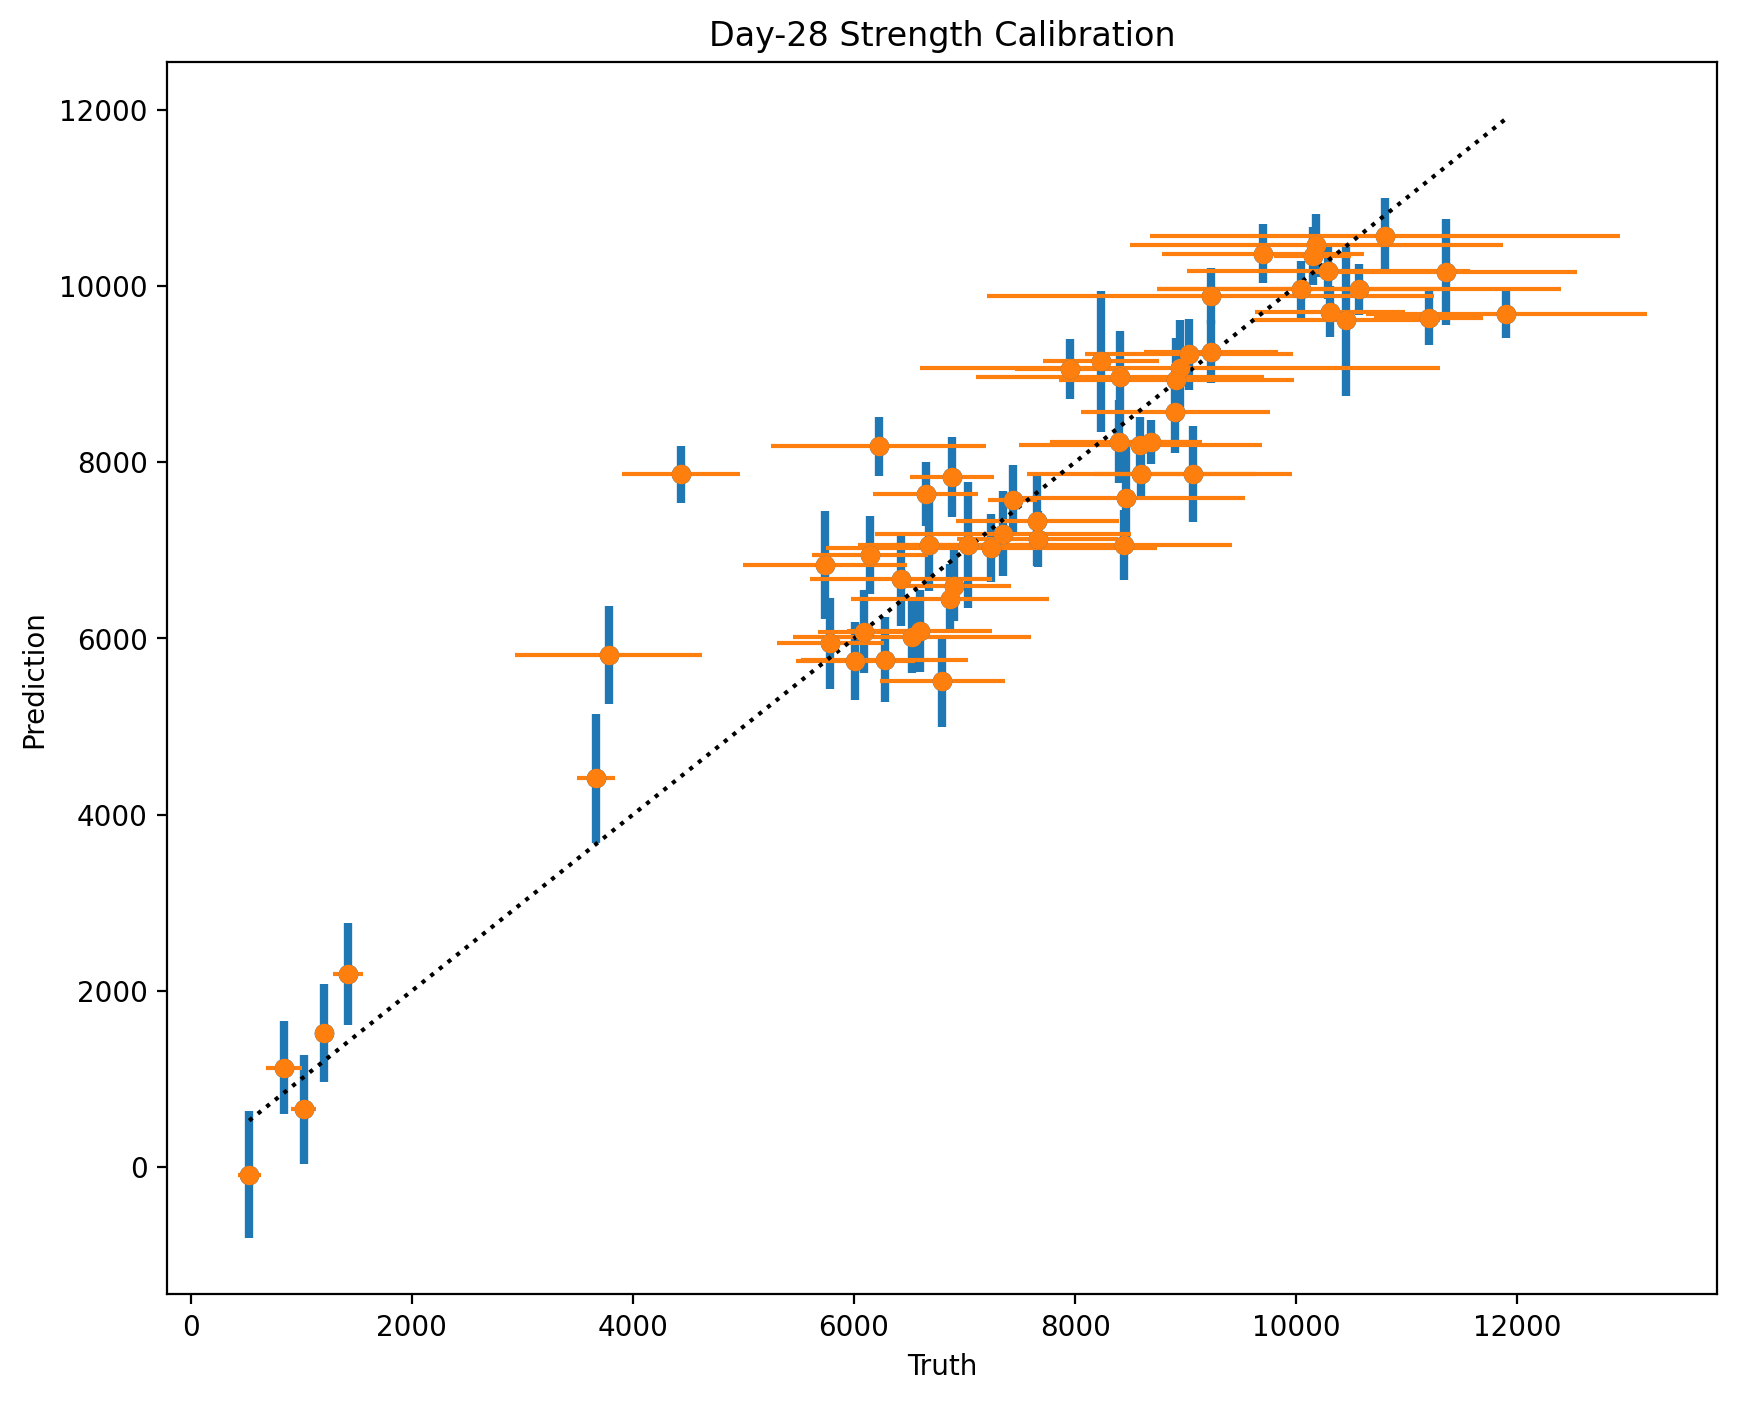

In [18]:
time = 28
Xt, truth, truth_var = data.strength_data_by_time(time)
truth = truth.squeeze()
truth_std = truth_var.sqrt().squeeze()

post_t = model.strength_model.posterior(Xt)
pred = post_t.mean.detach().squeeze()
pred_std = post_t.variance.sqrt().detach().squeeze()

fig = plt.figure(dpi=200)
plt.title(f"Day-{time} Strength Calibration")
plt.ylabel("Prediction")
plt.xlabel("Truth")
plt.scatter(truth, pred)
lw = 3
plt.errorbar(truth, pred, yerr=2 * pred_std, fmt="o", linewidth=lw)
plt.errorbar(truth, pred, xerr=2 * truth_std, fmt="o", linewidth=lw/2)
line = torch.arange(truth.min(), truth.max())
plt.plot(line, line, color="black", linestyle=":")
plt.show()

In [19]:
# fig.savefig("28_day_strength_callibration_fourth_batch.pdf", bbox_inches='tight')

## Strength Curve Predictions

In [20]:
## Example 1: Select a mix in the data set that we want to plot
X = data.gwp_data[0]
mix_ind = 21 # this selects which mix from the database we want to plot
X_plot = X[[mix_ind]] # follows: cement, fly ash, slag, water, HRWR, fine agg 
## Example 2: manually specify the composition
manual_specify = 1
if manual_specify == 1:
    X_plot[0,0] = 210.   # cement
    X_plot[0,1] = 110.   # fly ash
    X_plot[0,2] = 180.   # slag
    X_plot[0,3] = 180.   # water
    X_plot[0,4] =   2.   # HRWR
    X_plot[0,5] = 1400.  # fine agg
# print the formula
print('== mix tested ==')
print('cement:   ' + str(X_plot[0,0].item()))
print('fly ash:  ' + str(X_plot[0,1].item()))
print('slag:     ' + str(X_plot[0,2].item()))
print('water:    ' + str(X_plot[0,3].item()))
print('hrwr:     ' + str(X_plot[0,4].item()))
print('fine agg: ' + str(X_plot[0,5].item()))
print('w/b:      ' + str(X_plot[0,3].item()/(X_plot[0,0].item()+ X_plot[0,1].item()+ X_plot[0,2].item())))

Bounds do not hold in training data: X_bounds[0, :], X.amin(dim=0) = (tensor([  0.,   0.,   0.,  35.,   0., 925.,   0.]), tensor([  37.0000,    0.0000,    0.0000,   32.0000,    0.0000, 1132.5000,
           4.5000], dtype=torch.float64))X_bounds[1, :], X.amax(dim=0) = (tensor([ 950.,  950.,  950.,  475.,   95., 1775.,   40.]), tensor([ 671.,  225.,  325.,  238.,   10., 1768.,   22.], dtype=torch.float64))
== mix tested ==
cement:   210.0
fly ash:  110.0
slag:     180.0
water:    180.0
hrwr:     2.0
fine agg: 1400.0
w/b:      0.36


== mix tested ==
cement:   210.0
fly ash:  110.0
slag:     180.0
water:    180.0
hrwr:     2.0
fine agg: 1400.0
w/b:      0.36


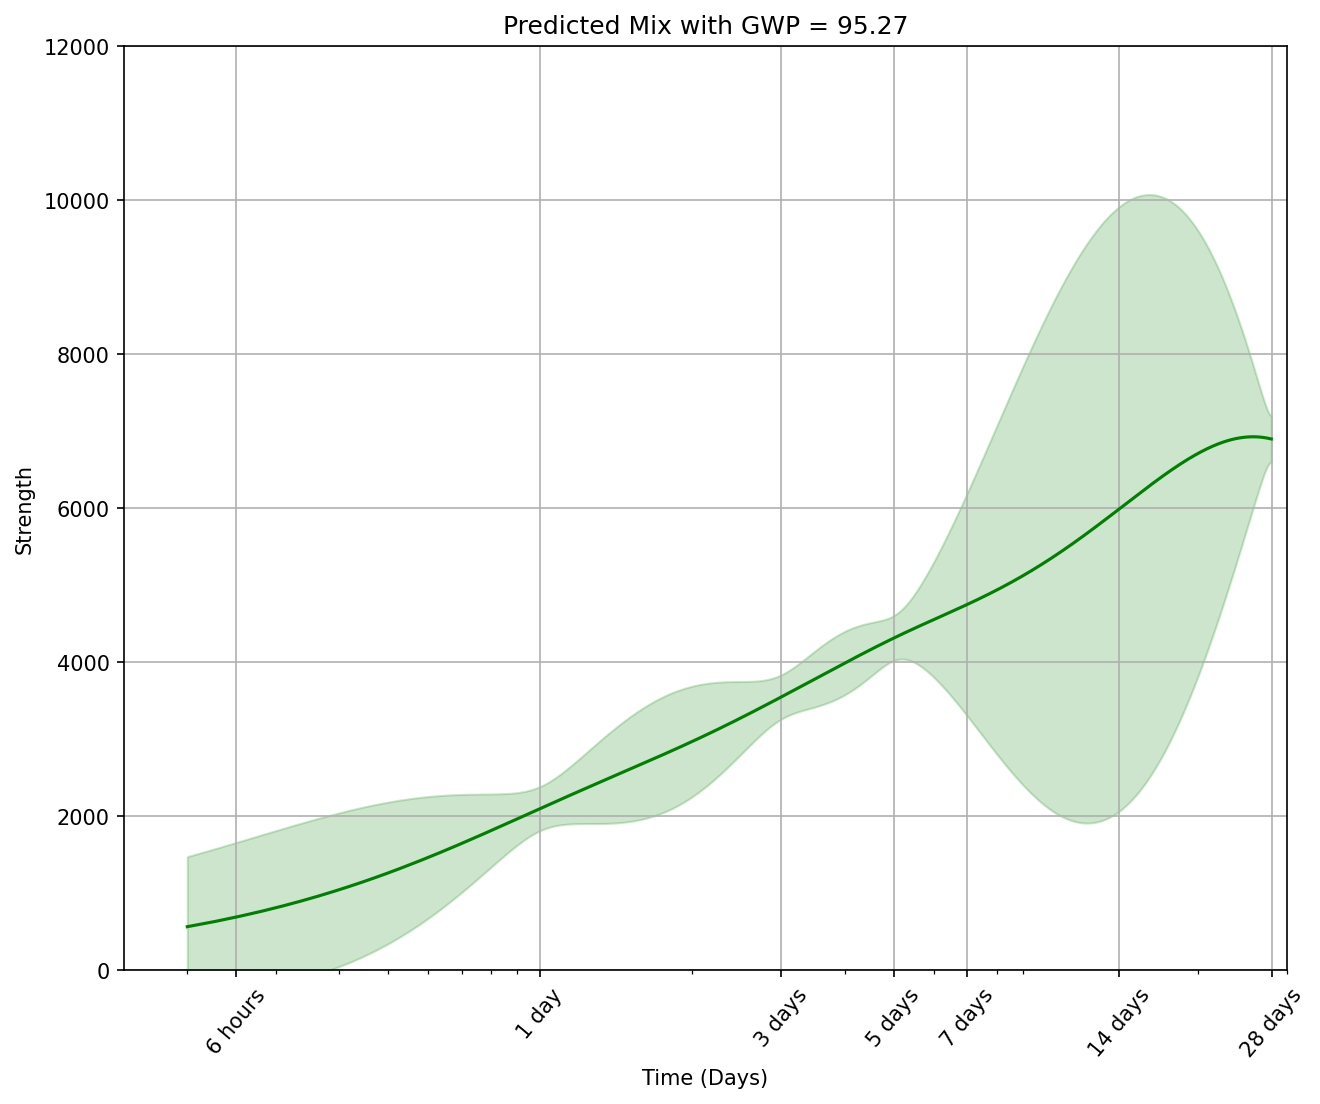

<Figure size 600x600 with 0 Axes>

In [21]:
## Run GWP and strength curve predictions
gwp_pred = model.gwp_model.posterior(X_plot).mean

t_start, t_stop = 0.2, 28.0
num_t = 1024    # default value is 1024
plot_times = torch.arange(t_start, t_stop, step=(t_stop - t_start) / num_t)

#plot_times = torch.tensor([0.2, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 5.0, 28.0])
#num_t = plot_times.size(dim=0)

# adding time dimension to composition inputs
X_w_time = torch.cat(
    (X_plot.expand(num_t, X_plot.shape[-1]), plot_times.unsqueeze(-1)), dim=-1
)

curve_post = model.strength_model.posterior(X_w_time)
curve_mean = curve_post.mean.detach().squeeze()
curve_std = curve_post.variance.sqrt().detach().squeeze()

# print the formula
print('== mix tested ==')
print('cement:   ' + str(X_plot[0,0].item()))
print('fly ash:  ' + str(X_plot[0,1].item()))
print('slag:     ' + str(X_plot[0,2].item()))
print('water:    ' + str(X_plot[0,3].item()))
print('hrwr:     ' + str(X_plot[0,4].item()))
print('fine agg: ' + str(X_plot[0,5].item()))
print('w/b:      ' + str(X_plot[0,3].item()/(X_plot[0,0].item()+ X_plot[0,1].item()+ X_plot[0,2].item())))



## Generate plot
color_1 = "green"
fig = plt.figure(dpi=150)
plt.title(f"Predicted Mix with GWP = {-gwp_pred.round(decimals=2).item()}")
plt.plot(plot_times, curve_mean, color=color_1)
plt.ylabel("Strength")
plt.xlabel("Time (Days)")
nsigma = 2
# plot uncertainties or not
plot_uncertainties = 1;
if plot_uncertainties == 1:
    plt.fill_between(
        plot_times,
        curve_mean - nsigma * curve_std,
        curve_mean + nsigma * curve_std,
        alpha=0.2,
        label="Predictions",
        color=color_1,
    )

# if the mix is in the dataset, could grab the observed strength data ("observed_data") from Y
# plt.plot(observed_times, observed_data, "o", label="Observations", c=color_1)
# plt.legend()

plt.xscale("log")
special_times = [6 / 24, 1, 3, 5, 7, 14, 28]
special_labels = [
    "6 hours",
    "1 day",
    "3 days",
    "5 days",
    "7 days",
    "14 days",
    "28 days",
]
plt.xticks(special_times, special_labels, rotation=50)
plt.grid(visible=True)

xlim = (0.15, 30)
ylim = (0, 12000)
plt.xlim(xlim)
plt.ylim(ylim)
plt.figure(figsize=(6,6))
plt.show()